In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -q "/content/gdrive/MyDrive/wavs.zip"

In [4]:
wavs="wavs"

In [5]:
from google.colab import files

uploaded = files.upload()

Saving Session1.xlsx to Session1.xlsx


In [6]:
wavs_df=pd.read_excel("Session1.xlsx", engine='openpyxl')

In [7]:
wavs_df['wav_file']= '/' + 'content' + '/' + 'wavs' + '/' + wavs_df['wav_file'].astype(str) + '.wav'

In [8]:
data_path=wavs_df.drop(columns=['start_time', 'end_time','val','act','dom'])

In [9]:
data_path

,Unnamed: 0,wav_file,emotion
0,0,/content/wavs/Ses01F_impro04_F000.wav,neu
1,1,/content/wavs/Ses01F_impro04_F001.wav,neu
2,2,/content/wavs/Ses01F_impro04_F002.wav,fru
3,5,/content/wavs/Ses01F_impro04_F005.wav,neu
4,6,/content/wavs/Ses01F_impro04_F006.wav,neu
...,...,...,...
7375,2162,/content/wavs/Ses05M_impro02_M025.wav,sad
7376,2164,/content/wavs/Ses05M_impro02_M027.wav,sad
7377,2165,/content/wavs/Ses05M_impro02_M028.wav,sad
7378,2166,/content/wavs/Ses05M_impro02_M029.wav,sad


In [10]:
def extract_features(data):
    
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data).T, axis=0)
    result = np.hstack((result, mfcc))
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path)
    res1 = extract_features(data)
    result = np.array(res1)
    result = np.vstack((result, res1)) 
    
    return result


In [11]:
X, Y = [], []
for path, emotion in (zip(data_path.wav_file, data_path.emotion)):
    soundpath = path.split('/')
    
    path = os.path.join(wavs,soundpath[-1])
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [12]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features5.csv', index=False)
Features.head()
Features=pd.read_csv('features5.csv')

In [13]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [18]:
Y[0]

4

In [19]:
import pickle
output = open('encoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

In [21]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11070, 148), (11070,), (3690, 148), (3690,))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
output1 = open('scaler.pkl', 'wb')
pickle.dump(scaler, output1)
output1.close()


In [ ]:
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11070, 148, 1), (11070,), (3690, 148, 1), (3690,))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(tf.keras.layers.BatchNormalization())

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(tf.keras.layers.BatchNormalization())

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(tf.keras.layers.BatchNormalization())

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(tf.keras.layers.BatchNormalization())

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 148, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 256)           1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 256)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 128)           1

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
es =  tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=25,
        verbose=1,
    )
history=model.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test), callbacks=[rlrp,es])

Epoch 1/500
173/173 [==============================] - 53s 299ms/step - loss: 1.6270 - accuracy: 0.3196 - val_loss: 1.9301 - val_accuracy: 0.2854
Epoch 2/500
173/173 [==============================] - 53s 305ms/step - loss: 1.5480 - accuracy: 0.3591 - val_loss: 1.8618 - val_accuracy: 0.2940
Epoch 3/500
173/173 [==============================] - 53s 305ms/step - loss: 1.5255 - accuracy: 0.3676 - val_loss: 1.4818 - val_accuracy: 0.3946
Epoch 4/500
173/173 [==============================] - 51s 292ms/step - loss: 1.5013 - accuracy: 0.3816 - val_loss: 1.4938 - val_accuracy: 0.3759
Epoch 5/500
173/173 [==============================] - 51s 294ms/step - loss: 1.4836 - accuracy: 0.3932 - val_loss: 1.4577 - val_accuracy: 0.3894
Epoch 6/500
173/173 [==============================] - 52s 300ms/step - loss: 1.4697 - accuracy: 0.4019 - val_loss: 1.4434 - val_accuracy: 0.4214
Epoch 7/500
173/173 [==============================] - 51s 298ms/step - loss: 1.4471 - accuracy: 0.4142 - val_loss: 1.4152 -

In [ ]:
len(history.history['accuracy'])

73

In [ ]:
history

116/116 [==============================] - 5s 41ms/step - loss: 1.3050 - accuracy: 0.8442
Accuracy of our model on test data :  84.41734313964844 %


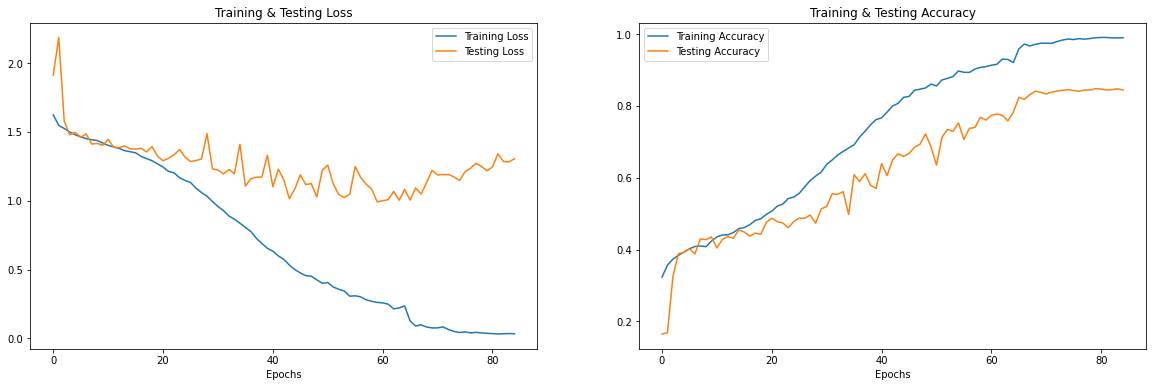

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

# epochs = [i for i in range(model.nb_epochs)]
epochs = history.epoch
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
model_name = 'Emotion_Voice_Detection_Model5.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model5.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model5.json", "w") as json_file:
    json_file.write(model_json)